In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data_2012 = pd.read_csv('BPI_2012.csv')
data_2012.head(15)

,case,event,startTime,completeTime,AMOUNT_REQ,REG_DATE,org:resource
0,173688,A_SUBMITTED,2011/10/01 00:38:44.546,2011/10/01 00:38:44.546,20000,2011/10/01 00:38:44.546,112
1,173688,A_PARTLYSUBMITTED,2011/10/01 00:38:44.880,2011/10/01 00:38:44.880,20000,2011/10/01 00:38:44.546,112
2,173688,A_PREACCEPTED,2011/10/01 00:39:37.906,2011/10/01 00:39:37.906,20000,2011/10/01 00:38:44.546,112
3,173688,A_PREACCEPTED,2011/10/01 00:39:37.906,2011/10/01 00:39:37.906,20000,2011/10/01 00:38:44.546,112
4,173688,W_Completeren aanvraag,2011/10/01 11:36:46.437,2011/10/01 11:45:13.917,20000,2011/10/01 00:38:44.546,112
5,173688,A_ACCEPTED,2011/10/01 11:42:43.308,2011/10/01 11:42:43.308,20000,2011/10/01 00:38:44.546,10862
6,173688,O_SELECTED,2011/10/01 11:45:09.243,2011/10/01 11:45:09.243,20000,2011/10/01 00:38:44.546,10862
7,173688,A_FINALIZED,2011/10/01 11:45:09.243,2011/10/01 11:45:09.243,20000,2011/10/01 00:38:44.546,10862
8,173688,O_CREATED,2011/10/01 11:45:11.197,2011/10/01 11:45:11.197,20000,2011/10/01 00:38:44.546,10862
9,173688,O_SENT,2011/10/01 11:45:11.380,2011/10/01 11:45:11.380,20000,2011/10/01 00:38:44.546,10862


In [3]:
data_2012 = data_2012.loc[:5035]

In [4]:
data_2012['nextEvent'] = data_2012['event']

In [10]:
# making a list with all the case id's
lst_caseID = []
for x in data_2012['case']:
    lst_caseID.append(x)
lst_case_ID = []
for t in lst_caseID:
    if t not in lst_case_ID:
        lst_case_ID.append(t)
        
lst_case_ID

[173688,
 173691,
 173694,
 173697,
 173700,
 173703,
 173706,
 173709,
 173712,
 173715,
 173718,
 173721,
 173724,
 173727,
 173730,
 173733,
 173736,
 173739,
 173742,
 173745,
 173748,
 173751,
 173754,
 173757,
 173760,
 173763,
 173766,
 173769,
 173772,
 173775,
 173778,
 173781,
 173784,
 173787,
 173790,
 173793,
 173796,
 173799,
 173802,
 173805,
 173808,
 173811,
 173814,
 173817,
 173820,
 173823,
 173826,
 173829,
 173832,
 173835,
 173838,
 173841,
 173844,
 173847,
 173850,
 173853,
 173856,
 173859,
 173862,
 173865,
 173868,
 173871,
 173874,
 173877,
 173880,
 173883,
 173886,
 173889,
 173892,
 173895,
 173898,
 173901,
 173904,
 173907,
 173910,
 173913,
 173916,
 173919,
 173922,
 173925,
 173928,
 173931,
 173934,
 173937,
 173940,
 173943,
 173946,
 173949,
 173952,
 173955,
 173958,
 173961,
 173964,
 173979,
 173982,
 173985,
 173988,
 173991,
 173994,
 173997,
 174000,
 174003,
 174006,
 174009,
 174012,
 174015,
 174018,
 174021,
 174024,
 174027,
 174030,
 

In [11]:
# using the process id's to seperate the processes and in the processes making an extra collumn with the next event.
# for the last event there is NaN, because there is no next event in that process.
for i in lst_case_ID:
    for r in data_2012[data_2012['case'] == i].T:
        if r + 1 in data_2012[data_2012['case'] == i].T:
            data_2012['nextEvent'][r] = data_2012['event'][r+1]
        else:
            data_2012['nextEvent'][r] = 'NaN'

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
# making dummy variables from the event, in this way the model can use all the different event types.
event = pd.get_dummies(data_2012['event'])

In [13]:
# put the dummy variables back in the dataframe, this time as columns.
df = pd.concat([data_2012, event], axis=1)
df.drop(['event'], axis=1, inplace=True)


In [14]:
# dropping the rows, the model don't need.
from sklearn.model_selection import train_test_split
X = df.drop(columns=['startTime', 'completeTime', 'REG_DATE', 'nextEvent', 'W_Valideren aanvraag', 'case', 'AMOUNT_REQ', 'org:resource'])
y = df['nextEvent']

In [15]:
# scaling all features 
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

In [16]:
# split the test and train data, without shuffle. this is because the processes should stay with each other
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
                                                    test_size=0.3, shuffle=False)

In [17]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

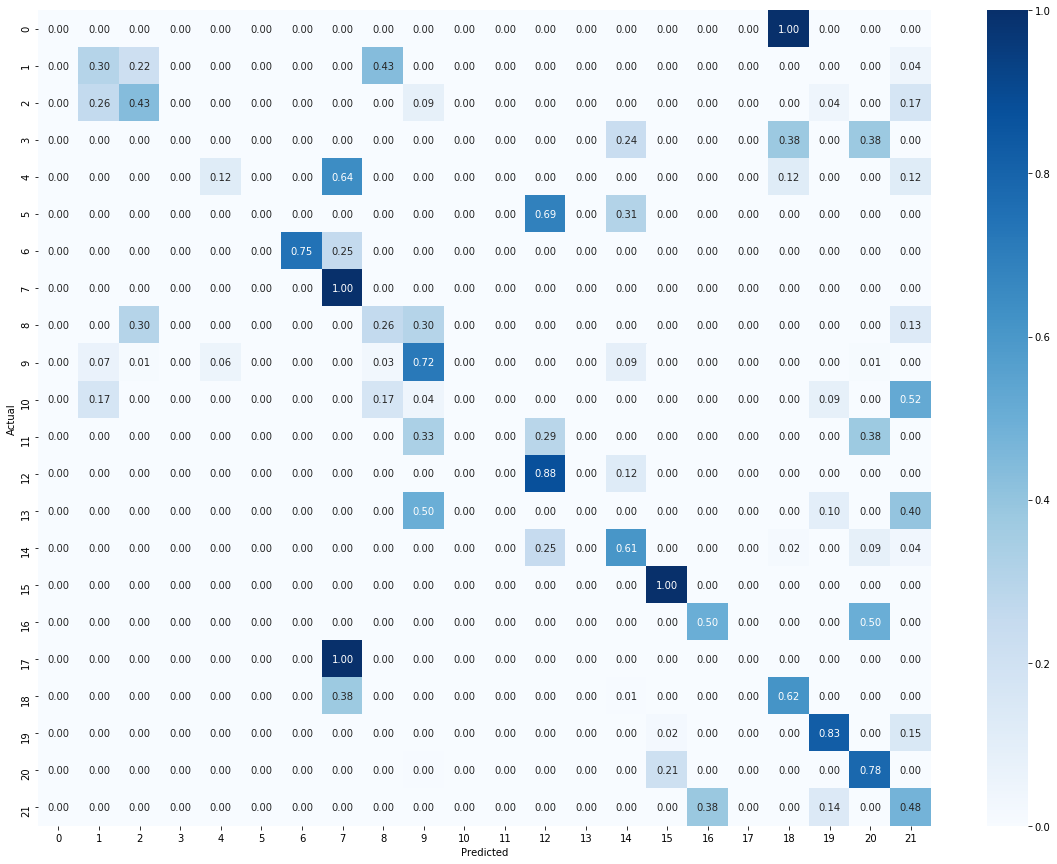

In [18]:
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
cm =confusion_matrix(y_test, rfc_pred)

# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(cmn, annot=True, fmt='.2f', cmap='Blues', ax=ax)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [19]:
classification_report(y_test, rfc_pred, output_dict = True)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'A_ACCEPTED': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 45},
 'A_ACTIVATED': {'precision': 0.30434782608695654,
  'recall': 0.30434782608695654,
  'f1-score': 0.30434782608695654,
  'support': 23},
 'A_APPROVED': {'precision': 0.43478260869565216,
  'recall': 0.43478260869565216,
  'f1-score': 0.43478260869565216,
  'support': 23},
 'A_CANCELLED': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 21},
 'A_DECLINED': {'precision': 0.5,
  'recall': 0.11904761904761904,
  'f1-score': 0.1923076923076923,
  'support': 42},
 'A_FINALIZED': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 45},
 'A_PARTLYSUBMITTED': {'precision': 1.0,
  'recall': 0.7456140350877193,
  'f1-score': 0.8542713567839196,
  'support': 114},
 'A_PREACCEPTED': {'precision': 0.4312267657992565,
  'recall': 1.0,
  'f1-score': 0.6025974025974026,
  'support': 116},
 'A_REGISTERED': {'precision': 0.2608695652173913,
  'recall': 0.2608695652173913,
  'f1-score